In [16]:
import geopandas as gpd
import os
import pandas as pd
import requests
import folium
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

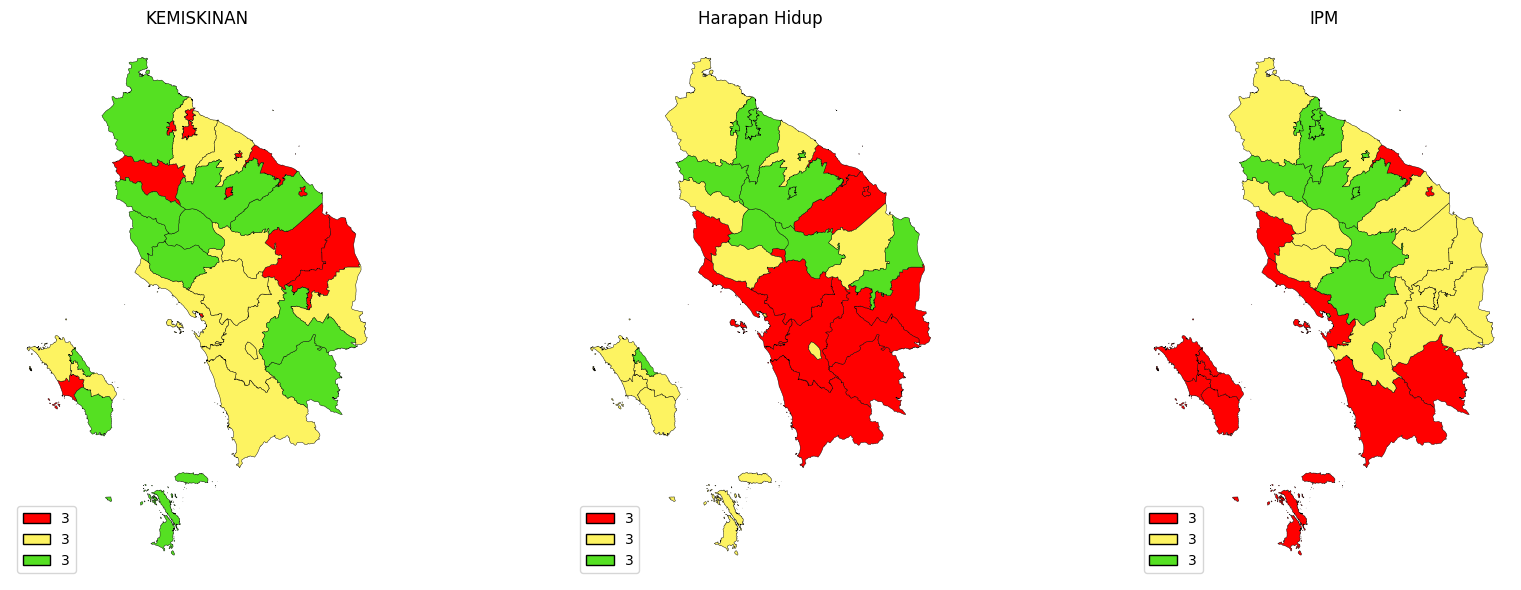

In [17]:
urls = {
"Kemiskinan":"https://geoserver.mapid.io/layers_new/get_layer?api_key=b32324f63a1546d4b9f7d9a1b7a7cc32&layer_id=68ad083db2fcc5561a307079&project_id=689dccff14ff9e48206a9468",
"Harapan hidup" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=b32324f63a1546d4b9f7d9a1b7a7cc32&layer_id=68ad087bb2fcc5561a3070cf&project_id=689dccff14ff9e48206a9468",
"IPM" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=b32324f63a1546d4b9f7d9a1b7a7cc32&layer_id=68ad0884b2fcc5561a307129&project_id=689dccff14ff9e48206a9468"
}

def get_data(url, layer_name):
    response = requests.get(url)
    if response.status_code == 200:
        geojson_data = response.json()
        gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

        if layer_name == "Kemiskinan":
            gdf["SKOR_KEMISKINAN"] = pd.qcut(gdf["GARIS KEMISKINAN"].astype(float), 
                                             q=3, 
                                             labels=[3,2,1] ).astype(int).fillna(0)
        
        elif layer_name == "Harapan hidup":
            for col in ["AHH_LAKI", "AHH_PEREMPUAN"]:
                gdf[col] = pd.to_numeric(gdf[col].astype(str).str.replace(",", ".", regex=False), errors="coerce")
            gdf["AHH_RATA2"] = gdf[["AHH_LAKI", "AHH_PEREMPUAN"]].mean(axis=1)
            gdf["SKOR_AHH"] = pd.qcut(gdf["AHH_RATA2"].astype(float),
                                      q=3,
                                      labels=[1,2,3]).astype(int).fillna(0)

        elif layer_name == "IPM":
            gdf["SKOR_IPM"] = pd.qcut(gdf["IPM 2024"].astype(float), 
                                    q=3, 
                                    labels=[1,2,3] ).astype(int).fillna(0)

    return gdf

gdf_kemiskinan = get_data(urls["Kemiskinan"], "Kemiskinan")
gdf_harapanhidup = get_data(urls["Harapan hidup"], "Harapan hidup")
gdf_IPM = get_data(urls["IPM"], "IPM")

def visualize_by_score(gdfs: dict, score_cols: dict):
    """
    gdfs       : {"KEMISKINAN": gdf_kemiskinan, "Harapan Hidup": gdf_harapanhidup, "IPM": gdf_ipm}
    score_cols : {"KEMISKINAN":"SKOR_KEMISKINAN","Harapan Hidup":"SKOR_AHH","IPM":"SKOR_IPM"}
    """
    n = len(gdfs)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
    if n == 1:  
        axes = [axes]

    color_for = {1: "#ff0000", 2: "#fdf361", 3: "#55e022"}   # low → high
    legend_labels = {1: "3", 2: "3", 3: "3"}

    for ax, (name, gdf) in zip(axes, gdfs.items()):
        col = score_cols[name]
        if col not in gdf.columns:
            ax.text(0.5, 0.5, f"Kolom '{col}' tidak ada", ha="center", va="center")
            ax.set_axis_off()
            continue

        for s in [1, 2, 3]:
            subset = gdf[gdf[col] == s]
            if len(subset) > 0:
                subset.plot(ax=ax, color=color_for[s], edgecolor="black", linewidth=0.3)

        ax.set_title(name)
        ax.set_axis_off()

        handles = [Patch(facecolor=color_for[s], edgecolor='black', label=legend_labels[s]) for s in [1,2,3]]
        ax.legend(handles=handles, loc="lower left", frameon=True)

    plt.tight_layout()
    plt.show()

gdfs = {
    "KEMISKINAN": gdf_kemiskinan,
    "Harapan Hidup": gdf_harapanhidup,
    "IPM": gdf_IPM
}

score_cols = {
    "KEMISKINAN": "SKOR_KEMISKINAN",
    "Harapan Hidup": "SKOR_AHH",
    "IPM": "SKOR_IPM"
}

visualize_by_score(gdfs, score_cols)

In [19]:
from shapely import make_valid
from shapely.ops import unary_union

def normalize_to_polygons(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Bersihkan geometri dan pastikan hanya Polygon/MultiPolygon (homogen)."""
    gdf = gdf[~gdf.geometry.isna()].copy()
    gdf["geometry"] = gdf.geometry.apply(lambda g: make_valid(g) if not g.is_valid else g)

    def to_polygonal(geom):
        if geom is None or geom.is_empty:
            return None
        t = geom.geom_type
        if t in ("Polygon", "MultiPolygon"):
            return geom
        if t == "GeometryCollection":
            polys = [gg for gg in geom.geoms if gg.geom_type in ("Polygon","MultiPolygon")]
            if not polys:
                return None
            return unary_union(polys)
        return None

    gdf["geometry"] = gdf.geometry.apply(to_polygonal)
    gdf = gdf[~gdf.geometry.isna() & ~gdf.geometry.is_empty].copy()
    gdf = gdf.explode(index_parts=False, ignore_index=True)
    assert gdf.geom_type.isin(["Polygon"]).all() or gdf.geom_type.isin(["Polygon","MultiPolygon"]).all()
    return gdf

target_crs = gdf_kemiskinan.crs
for g in (gdf_harapanhidup, gdf_IPM):
    if g.crs != target_crs:
        g.to_crs(target_crs, inplace=True)

gdf_kemiskinan["SKOR_KEMISKINAN"] = pd.to_numeric(gdf_kemiskinan["SKOR_KEMISKINAN"], errors="coerce").fillna(0).astype(int)
gdf_harapanhidup["SKOR_AHH"]      = pd.to_numeric(gdf_harapanhidup["SKOR_AHH"], errors="coerce").fillna(0).astype(int)
gdf_IPM["SKOR_IPM"]               = pd.to_numeric(gdf_IPM["SKOR_IPM"], errors="coerce").fillna(0).astype(int)

gdf_kemiskinan   = normalize_to_polygons(gdf_kemiskinan)
gdf_harapanhidup = normalize_to_polygons(gdf_harapanhidup)
gdf_IPM          = normalize_to_polygons(gdf_IPM)

intersection_gdf = gpd.overlay(gdf_kemiskinan, gdf_harapanhidup, how="intersection")  # keep_geom_type default True; sudah homogen
intersection_gdf = gpd.overlay(intersection_gdf, gdf_IPM, how="intersection")

for col in ["SKOR_KEMISKINAN", "SKOR_AHH", "SKOR_IPM"]:
    if col not in intersection_gdf.columns:
        intersection_gdf[col] = 0
    intersection_gdf[col] = pd.to_numeric(intersection_gdf[col], errors="coerce").fillna(0).astype(int)

intersection_gdf["SKOR_TOTAL"] = (
    intersection_gdf["SKOR_KEMISKINAN"] +
    intersection_gdf["SKOR_AHH"] +
    intersection_gdf["SKOR_IPM"]
).astype(int)

intersection_gdf["TOTAL"] = pd.cut(
    intersection_gdf["SKOR_TOTAL"],
    bins=[2, 5, 7, 9],
    labels=["RENDAH","SEDANG","TINGGI"],
    include_lowest=True
)

print(intersection_gdf[["SKOR_KEMISKINAN","SKOR_AHH","SKOR_IPM","SKOR_TOTAL","TOTAL"]].head(10))


c:\Users\Lenovo\MAPID\.venv\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 118 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


   SKOR_KEMISKINAN  SKOR_AHH  SKOR_IPM  SKOR_TOTAL   TOTAL
0                1         1         1           3  RENDAH
1                1         1         1           3  RENDAH
2                1         1         1           3  RENDAH
3                1         1         1           3  RENDAH
4                1         1         1           3  RENDAH
5                1         3         3           7  SEDANG
6                1         3         3           7  SEDANG
7                3         1         1           5  RENDAH
8                1         3         3           7  SEDANG
9                2         3         3           8  TINGGI


c:\Users\Lenovo\MAPID\.venv\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 118 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [20]:
import os

output_dir = r"C:\Users\Lenovo\HASILAKHIR"
os.makedirs(output_dir, exist_ok=True)

def clean_polygonal(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf = gdf[~gdf.geometry.isna()].copy()
    # make_valid per fitur
    gdf["geometry"] = gdf.geometry.apply(lambda geom: make_valid(geom) if not geom.is_valid else geom)
    # buang yang masih invalid/empty
    gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty].copy()
    # simpan hanya Polygon/MultiPolygon
    gdf = gdf[gdf.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()
    # pecah MultiPolygon -> Polygon
    gdf = gdf.explode(index_parts=False, ignore_index=True)
    return gdf

target_crs = gdf_kemiskinan.crs
for g in (gdf_harapanhidup, gdf_IPM):
    if g.crs != target_crs:
        g.to_crs(target_crs, inplace=True)

kemiskinan_out   = clean_polygonal(gdf_kemiskinan)
ahh_out          = clean_polygonal(gdf_harapanhidup)
ipm_out          = clean_polygonal(gdf_IPM)
intersection_out = clean_polygonal(intersection_gdf)

for df, cols in [
    (kemiskinan_out, ["SKOR_KEMISKINAN"]),
    (ahh_out,        ["SKOR_AHH"]),
    (ipm_out,        ["SKOR_IPM"]),
    (intersection_out, ["SKOR_KEMISKINAN","SKOR_AHH","SKOR_IPM","SKOR_TOTAL"])
]:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

kemiskinan_path   = os.path.join(output_dir, "kemiskinan.geojson")
ahh_path          = os.path.join(output_dir, "harapan_hidup.geojson")
ipm_path          = os.path.join(output_dir, "ipm.geojson")
intersection_path = os.path.join(output_dir, "hasil_intersect.geojson")

kemiskinan_out.to_file(kemiskinan_path, driver="GeoJSON")
ahh_out.to_file(ahh_path, driver="GeoJSON")
ipm_out.to_file(ipm_path, driver="GeoJSON")
intersection_out.to_file(intersection_path, driver="GeoJSON")

print("Data berhasil disimpan di:", output_dir)
print("File:")
print(" -", kemiskinan_path)
print(" -", ahh_path)
print(" -", ipm_path)
print(" -", intersection_path)


c:\Users\Lenovo\MAPID\.venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
c:\Users\Lenovo\MAPID\.venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
c:\Users\Lenovo\MAPID\.venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
c:\Users\Lenovo\MAPID\.venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Data berhasil disimpan di: C:\Users\Lenovo\HASILAKHIR
File:
 - C:\Users\Lenovo\HASILAKHIR\kemiskinan.geojson
 - C:\Users\Lenovo\HASILAKHIR\harapan_hidup.geojson
 - C:\Users\Lenovo\HASILAKHIR\ipm.geojson
 - C:\Users\Lenovo\HASILAKHIR\hasil_intersect.geojson
